In [1]:
pip install yfinance pandas numpy matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# change these if you want
ticker = "AAPL"
period = "1y"   # e.g. "6mo", "1y"

In [3]:
t = yf.Ticker(ticker)
hist = t.history(period=period)
hist = hist.reset_index()
# show last 3 rows
hist.tail(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
248,2025-10-01 00:00:00-04:00,255.039993,258.790009,254.929993,255.449997,48713900,0.0,0.0
249,2025-10-02 00:00:00-04:00,256.579987,258.179993,254.149994,257.130005,42597200,0.0,0.0
250,2025-10-03 00:00:00-04:00,254.664993,259.239990,253.960007,258.440002,23447735,0.0,0.0


In [4]:
expiries = t.options
print("Available expiries:", expiries)


Available expiries: ('2025-10-03', '2025-10-10', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-04-17', '2026-05-15', '2026-06-18', '2026-08-21', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17', '2028-01-21')


In [5]:
# choose index 0 (first) or change index to another expiry
expiry = expiries[0]
print("Selected expiry:", expiry)

chain = t.option_chain(expiry)
calls = chain.calls.copy()
puts  = chain.puts.copy()

# quick preview
print("Calls rows:", len(calls), "Puts rows:", len(puts))
calls.head(2), puts.head(2)

Selected expiry: 2025-10-03
Calls rows: 57 Puts rows: 54


(        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
 0  AAPL251003C00110000 2025-10-02 19:31:51+00:00   110.0     147.58  148.00   
 1  AAPL251003C00125000 2025-10-03 15:06:24+00:00   125.0     133.25  133.25   
 
       ask    change  percentChange  volume  openInterest  impliedVolatility  \
 0  149.00  0.000000       0.000000     1.0             2           5.187504   
 1  133.95  0.779999       0.588812     1.0             8           5.593753   
 
    inTheMoney contractSize currency  
 0        True      REGULAR      USD  
 1        True      REGULAR      USD  ,
         contractSymbol             lastTradeDate  strike  lastPrice  bid  \
 0  AAPL251003P00110000 2025-09-30 16:22:35+00:00   110.0       0.01  0.0   
 1  AAPL251003P00120000 2025-09-10 14:56:58+00:00   120.0       0.01  0.0   
 
     ask  change  percentChange  volume  openInterest  impliedVolatility  \
 0  0.01     0.0            0.0    10.0            62           4.875004   
 1  0.01     

In [6]:
for df in (calls, puts):
    if 'openInterest' in df.columns:
        df['openInterest'] = pd.to_numeric(df['openInterest'], errors='coerce').fillna(0).astype(int)
    else:
        df['openInterest'] = 0
    df['strike'] = pd.to_numeric(df['strike'], errors='coerce')

In [7]:
total_call_oi = calls['openInterest'].sum()
total_put_oi  = puts['openInterest'].sum()
ocr = (total_put_oi / total_call_oi) if total_call_oi>0 else np.nan
print("Total Call OI:", total_call_oi)
print("Total Put  OI:", total_put_oi)
print("Put/Call OI ratio:", round(ocr,3))

top_calls = calls.sort_values('openInterest', ascending=False).head(5)[['strike','openInterest','lastPrice']]
top_puts  = puts.sort_values('openInterest', ascending=False).head(5)[['strike','openInterest','lastPrice']]

print("\nTop 5 Calls:")
print(top_calls.to_string(index=False))
print("\nTop 5 Puts:")
print(top_puts.to_string(index=False))

Total Call OI: 254089
Total Put  OI: 124296
Put/Call OI ratio: 0.489

Top 5 Calls:
 strike  openInterest  lastPrice
  260.0         50387       0.24
  265.0         26538       0.02
  262.5         22491       0.05
  255.0         17865       3.55
  270.0         16724       0.01

Top 5 Puts:
 strike  openInterest  lastPrice
  255.0         14785       0.08
  250.0         14031       0.03
  240.0         11055       0.01
  247.5         10798       0.02
  252.5          9378       0.03


In [8]:
# spot price (latest close)
S = hist['Close'].iloc[-1]
print("Spot price (latest close):", S)

def compute_max_pain(calls_df, puts_df):
    strikes = sorted(set(calls_df['strike'].dropna().astype(float)).union(set(puts_df['strike'].dropna().astype(float))))
    pains = []
    for s in strikes:
        calls_loss = ((np.maximum(s - calls_df['strike'], 0)) * calls_df['openInterest']).sum()
        puts_loss  = ((np.maximum(puts_df['strike'] - s, 0)) * puts_df['openInterest']).sum()
        pains.append((s, calls_loss + puts_loss))
    pain_df = pd.DataFrame(pains, columns=['strike','pain']).sort_values('pain')
    return pain_df

pain_df = compute_max_pain(calls, puts)
max_pain = pain_df.iloc[0]
print("Max pain strike:", max_pain['strike'])
# show 5 lowest pain values (possible targets)
pain_df.head(5)

Spot price (latest close): 258.44000244140625
Max pain strike: 250.0


,strike,pain
35,250.0,835757.5
34,247.5,843412.5
33,245.0,887257.5
36,252.5,902362.5
32,242.5,966767.5


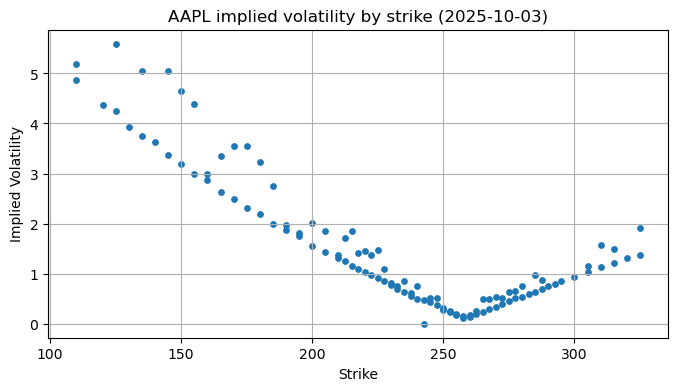

In [9]:
iv = pd.concat([
    calls[['strike','impliedVolatility']].assign(type='call'),
    puts[['strike','impliedVolatility']].assign(type='put')
]).dropna(subset=['impliedVolatility'])

plt.figure(figsize=(8,4))
plt.scatter(iv['strike'], iv['impliedVolatility'], s=15)
plt.title(f"{ticker} implied volatility by strike ({expiry})")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

In [10]:
calls.to_csv(f"{ticker}_calls_{expiry}.csv", index=False)
puts.to_csv(f"{ticker}_puts_{expiry}.csv", index=False)
pain_df.to_csv(f"{ticker}_pain_{expiry}.csv", index=False)
print("Saved CSVs to current folder.")

Saved CSVs to current folder.
